In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'C:\\Users\\mrity\\Documents\\PLant DD'
width=256
height=256
depth=3


In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing PlantVillage ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [7]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [8]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [9]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [10]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [11]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [13]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


C:\Users\mrity\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

<ipython-input-14-f5a41846f0f2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
73/73 [==============================] - 144s 2s/step - loss: 0.6171 - accuracy: 0.2173 - val_loss: 0.3224 - val_accuracy: 0.0541
Epoch 2/25
73/73 [==============================] - 145s 2s/step - loss: 0.1990 - accuracy: 0.4732 - val_loss: 1.3408 - val_accuracy: 0.0812
Epoch 3/25
73/73 [==============================] - 144s 2s/step - loss: 0.1320 - accuracy: 0.6410 - val_loss: 2.9147 - val_accuracy: 0.0778
Epoch 4/25
73/73 [==============================] - 145s 2s/step - loss: 0.1106 - accuracy: 0.7123 - val_loss: 0.7247 - val_accuracy: 0.0626
Epoch 5/25
73/73 [==============================] - 146s 2s/step - loss: 0.1039 - accuracy: 0.7295 - val_loss: 0.7535 - val_accuracy: 0.0643
Epoch 6/25
73/73 [==============================] - 146s 2s/step - loss: 0.0947 - accuracy: 0.7643 - val_loss: 0.8537 - val_accuracy: 0.1861
Epoch 7/25
73/73 [==============================] - 146s 2s/step - loss: 0.1031 - accuracy: 0.7398 - val_loss: 0.3641 - val_accuracy: 0.2944
Epoch 8/25
73

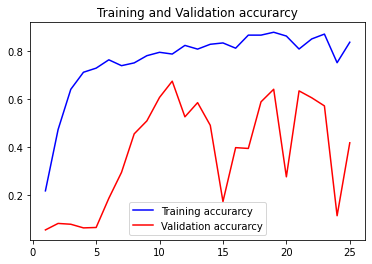

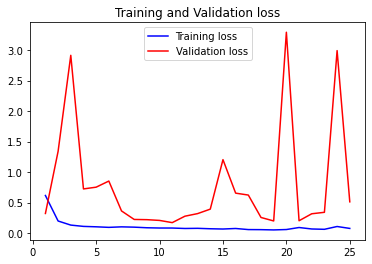

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [16]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 6s 296ms/step - loss: 0.5134 - accuracy: 0.4179
Test Accuracy: 41.793569922447205


In [17]:
print("[INFO] Saving model...")
model.save('D:\\Leaf Disease Detection\\Model save')

[INFO] Saving model...
INFO:tensorflow:Assets written to: D:\Leaf Disease Detection\Model save\assets


In [18]:
import keras
model = keras.models.load_model('D:\\Leaf Disease Detection\\Model save')

In [19]:
model = keras.models.load_model('D:\\Leaf Disease Detection\\Model save')

In [25]:
image_dir="C:\\Users\\mrity\\Documents\\PLant DD\\Dataset\\Pepper__bell___healthy\\0a3f2927-4410-46a3-bfda-5f4769a5aaf8___JR_HL 8275.JPG"

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [26]:
result=model.predict(npp_image)

print(result)

[[1.93470018e-09 9.99997139e-01 9.51303879e-12 9.74423228e-18
  1.06167235e-16 8.34164248e-12 2.88802676e-06 9.61894453e-10
  4.93696533e-12 1.25223032e-09 5.22812492e-17 3.91939140e-13
  1.09431186e-10 1.13341714e-12 2.79850985e-13]]


In [27]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.99999714
Pepper__bell___healthy
